In [ ]:
import torch
from torch import nn
import torchvision as tv
from torchsummary import summary
import time
import random
from matplotlib import pyplot as plt
import numpy as np
import json
import copy

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 10 if torch.cuda.is_available() else 10
device

'cpu'

Примечание: Все результаты получены на cuda, кроме DenseNet 161 (закончился лимит)

In [ ]:
model_dict = {
    "model_name": [],
    "ep": [],
    "taked": [],
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}
# словарь для хранения результатов моделей

#### Функция для построения графиков по результатам обучения и тестирования разных моделей.

Рисует пять графиков и легенду

Аргументы:
- model_dict - словарь, содержащий списки значений для эпох, времени, потерь и точности для каждой модели.
- best_list (необязательный) - список, содержащий имена моделей, которые отображаются на графиках

In [ ]:
def plt_show(model_dict, best_list = []):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
    fig.suptitle('Plots')
    leg = axs[0, 0]
    ax1 = axs[0, 1]
    ax2 = axs[1, 0]
    ax3 = axs[1, 1]
    ax4 = axs[2, 0]
    ax5 = axs[2, 1]

    for x, y, label in zip(model_dict['ep'] , model_dict['taked'], model_dict['model_name']):
        if (best_list and label in best_list) or not best_list:
            ax1.plot(x , y, label=label)
    ax1.set_xlabel('ep')
    ax1.set_ylabel('taked')
    ax1.set_title('time')

    for x, y, label in zip(model_dict['ep'] , model_dict['train_loss'], model_dict['model_name']):
        if (best_list and label in best_list) or not best_list:
            ax2.plot(x , y)
    ax2.set_xlabel('ep')
    ax2.set_ylabel('train_loss')
    ax2.set_title('train loss')

    for x, y, label in zip(model_dict['ep'] , model_dict['train_acc'], model_dict['model_name']):
        if (best_list and label in best_list) or not best_list:
            ax3.plot(x , y)
    ax3.set_xlabel('ep')
    ax3.set_ylabel('train_acc')
    ax3.set_title('train accuracy')

    for x, y, label in zip(model_dict['ep'] , model_dict['test_loss'], model_dict['model_name']):
        if (best_list and label in best_list) or not best_list:
            ax4.plot(x , y)
    ax4.set_xlabel('ep')
    ax4.set_ylabel('test_loss')
    ax4.set_title('test loss')

    for x, y, label in zip(model_dict['ep'] , model_dict['test_acc'], model_dict['model_name']):
        if (best_list and label in best_list) or not best_list:
            ax5.plot(x , y)
    ax5.set_xlabel('ep')
    ax5.set_ylabel('test_acc')
    ax5.set_title('test accuracy')
    
    leg.legend(*ax1.get_legend_handles_labels(), loc=2)
    leg.axis("off")

В функции train будем фиксировать значение функции потерь (train_loss и test_loss) в список для отображения для отображения в функции plt_show

In [ ]:
def evaluate_accuracy(test_iter, net_test):
    loss = nn.CrossEntropyLoss(reduction='sum')
    
    test_l_sum, test_acc_sum, test_n = 0.0, 0.0, 0
    net_test.eval()
    for X, y in test_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net_test(X)
        l = loss(y_hat, y)
        test_l_sum += l.item()
        test_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
        test_n += y.shape[0]
        return test_l_sum, test_acc_sum, test_n

Замечания:
- Модель Inceptionv3 имеет два выхода, поэтому нужно немного изменить функцию train (а именно loss)

In [ ]:
def train(net, train_iter, test_iter, trainer, num_epochs, net_name):
    ep_ = []
    taked_ = []
    train_loss_ = []
    train_acc_ = []
    test_loss_ = []
    test_acc_ = []
    
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, train_n, start = 0.0, 0.0, 0, time.time()
        
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)

            if net_name=='Inceptionv3':
                main_output, aux_output = y_hat[0], y_hat[1]
                main_loss = loss(main_output, y)
                aux_loss = loss(aux_output, y)
                l = main_loss + 0.2 * aux_loss
                y_hat = main_output
            else:
                l = loss(y_hat, y)

            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            train_n += y.shape[0]
        
        test_l_sum, test_acc_sum, test_n = evaluate_accuracy(test_iter, copy.deepcopy(net))
                
        ep_.append(epoch)
        taked_.append(time.time() - start)
        train_loss_.append(train_l_sum / train_n)
        train_acc_.append(train_acc_sum / train_n)
        test_loss_.append(test_l_sum / test_n)
        test_acc_.append(test_acc_sum / test_n)
        
        print('-' * 20)
        print(f'epoch {epoch + 1}, train loss {train_l_sum / train_n:.4f}, train acc {train_acc_sum / train_n:.3f}'
              f', test loss {test_l_sum / test_n:.4f}, test acc {test_acc_sum / test_n:.3f}'
              f', time {time.time() - start:.1f} sec')
    
    model_dict['model_name'].append(net_name)
    model_dict['ep'].append(ep_)
    model_dict['taked'].append(taked_)
    model_dict['train_loss'].append(train_loss_)
    model_dict['train_acc'].append(train_acc_)
    model_dict['test_loss'].append(test_loss_)
    model_dict['test_acc'].append(test_acc_)

## Загружаем датасет
Ссылки:
- 1. [torchvision.datasets.EMNIST](https://pytorch.org/vision/main/generated/torchvision.datasets.EMNIST.html)  
- 2. [The EMNIST Dataset](https://www.nist.gov/itl/products-and-services/emnist-dataset)
- 3. [эмнист](https://www.tensorflow.org/datasets/catalog/emnist?hl=ru)

In [ ]:
BATCH_SIZE = 256
transoforms = tv.transforms.Compose([
    tv.transforms.Resize((28, 28)),
    tv.transforms.ToTensor()
])
train_dataset = tv.datasets.EMNIST('.', split='byclass', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split='byclass', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

100%|██████████| 561753746/561753746 [01:17<00:00, 7273161.61it/s] 


Extracting .\EMNIST\raw\gzip.zip to .\EMNIST\raw


## Смотрим примеры картинок

Согласно описанию (ссылка 3), изображения инвертированы по горизонтали и повернуты на 90° против часовой стрелки. Поэтому сделаем необходимые действия, чтобы изображения отображались в нормальном виде.

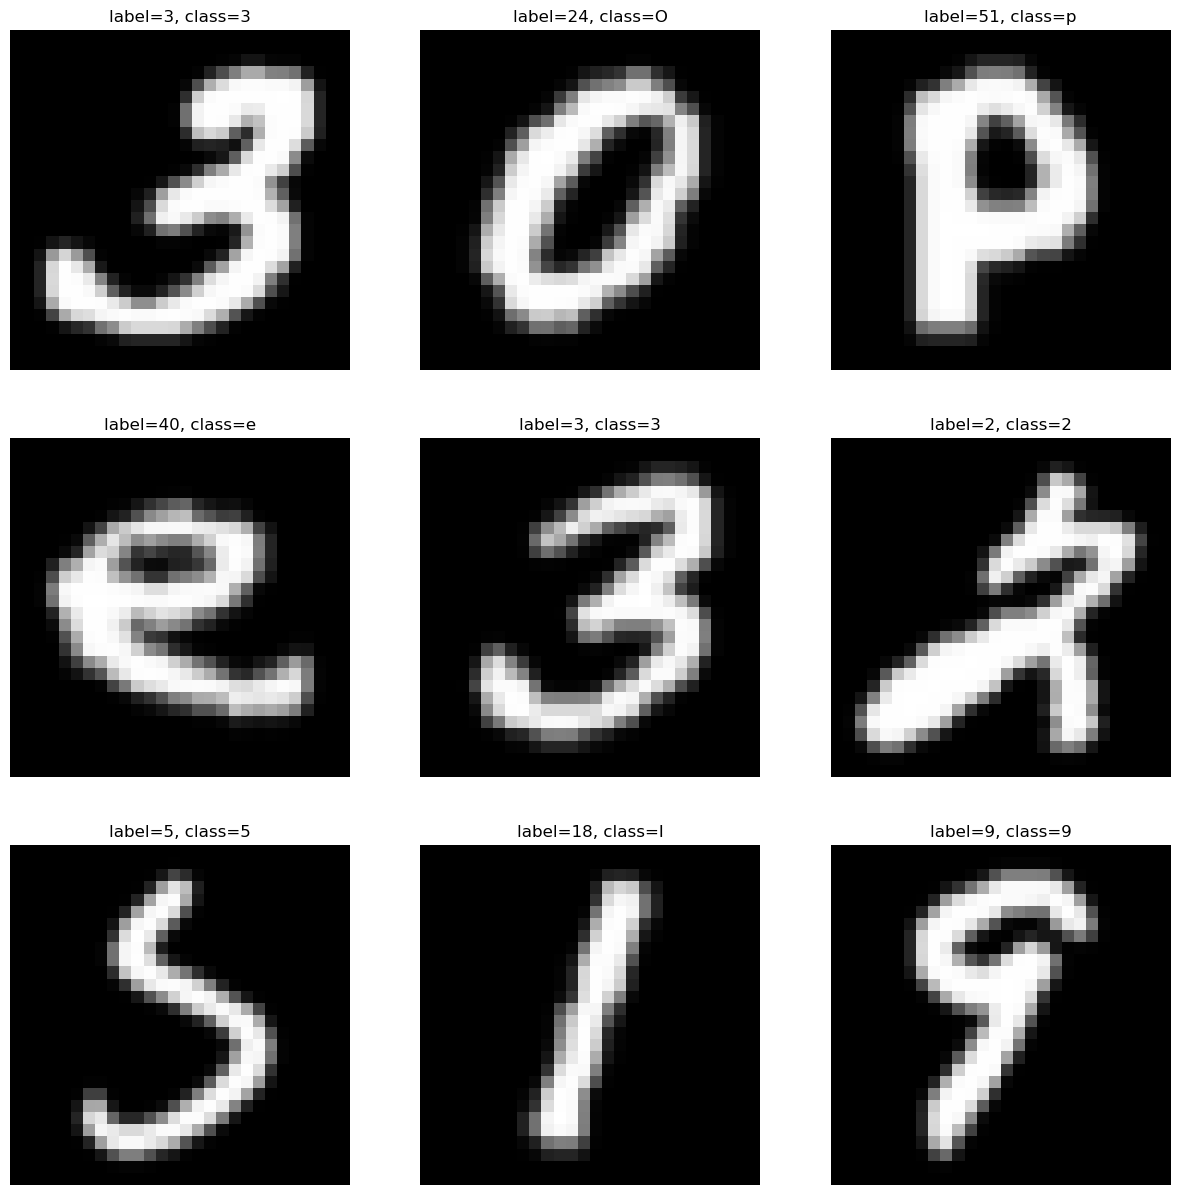

In [ ]:
indices = random.sample(range(0, len(train_dataset)-1), 9)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
class_dict = train_dataset.classes
for i, ax in zip(indices, axes.flatten()):
    image, label = train_dataset[i]
    class_ = class_dict[label]
    image = image.numpy().reshape(28,28)
    image = np.flip(image, axis=1)
    image = np.rot90(image, axes=(0, 1))
    ax.imshow(image, cmap='gray')
    ax.set_title(f'label={label}, class={class_}')
    ax.axis('off')


## Проверяем наличествующие классы и их дисбаланс
Так как мы при загрузке датасета выбрали значение byclass в параметре split, то, согласно описанию датасета (ссылка 2), мы ожидаем увидеть 62 небалансированных класса

In [ ]:
train_labels = train_dataset.targets.numpy()
test_labels = test_dataset.targets.numpy()
train_counts = np.bincount(train_labels)
test_counts = np.bincount(test_labels)
class_names = train_dataset.classes

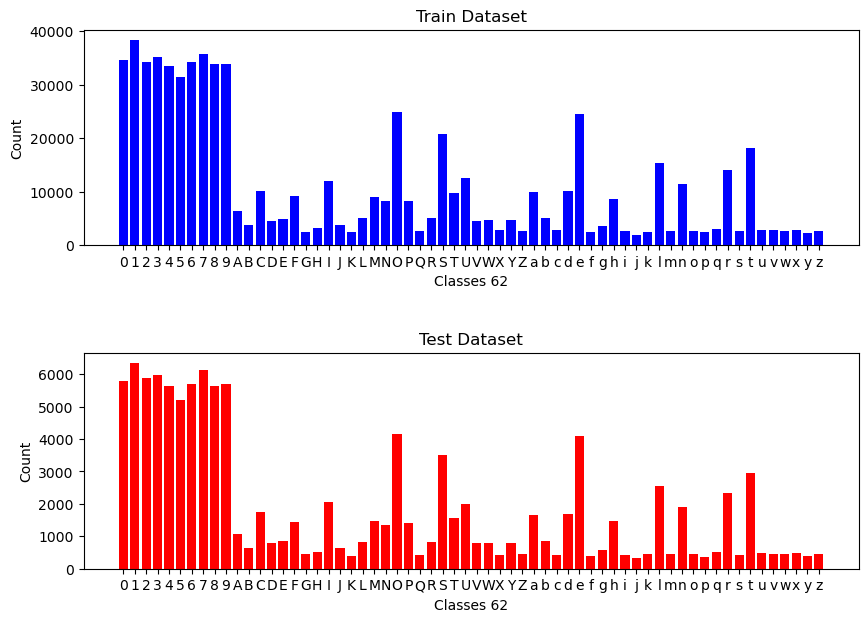

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))
ax1.bar(class_names, train_counts, color='blue')
ax1.set_title('Train Dataset')
ax1.set_xlabel(f'Classes {len(class_names)}')
ax1.set_ylabel('Count')
ax2.bar(class_names, test_counts, color='red')
ax2.set_title('Test Dataset')
ax2.set_xlabel(f'Classes {len(class_names)}') 
ax2.set_ylabel('Count')
plt.subplots_adjust(hspace=0.5)

## Создаем модель ResNet 18
[RESNET18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html)

Так как нужно обучить модель с нуля, нужно обнулить веса.  
Используем weights=None вместо pretrained=False, так как у меня появилось такое предупреждение:  
*UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`*

In [ ]:
model = tv.models.resnet18(weights=None)

На cuda если подавать изображение 224 на 224, то одна эпоха будет выполнятся 10 минут. Если 28 на 28, то не больше одной минуты. Поэтому будем подавать наше оригинальное изображение 28 на 28.  
- трансформируем изображения с 28 на 28 и одним каналом до 28 на 28 с тремя каналами
- для датасета EMNIST берем split=balanced, чтобы уменьшить время обучения

In [ ]:
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((28, 28)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', split='balanced', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split='balanced', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

последний слой fc имеет 1000 каналов, нам же нужно 47, так как у нас split=balanced

In [ ]:
model.fc = nn.Linear(in_features=512, out_features=47)

In [ ]:
model = model.to(device)

In [ ]:
summary(model, input_size=(3, 28, 28), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

## Обучаем модель с нуля 10 эпох

In [ ]:
params_to_update = model.parameters()
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
model_name = 'ResNet18'
train(model, train_iter, test_iter, trainer, num_epochs, model_name)

--------------------
epoch 1, train loss 0.5451, train acc 0.816, test loss 0.4750, test acc 0.836, time 45.4 sec
--------------------
epoch 2, train loss 0.8748, train acc 0.739, test loss 0.4330, test acc 0.845, time 45.4 sec
--------------------
epoch 3, train loss 0.3711, train acc 0.865, test loss 0.3855, test acc 0.858, time 44.7 sec
--------------------
epoch 4, train loss 0.3267, train acc 0.878, test loss 0.3755, test acc 0.863, time 46.1 sec
--------------------
epoch 5, train loss 0.3022, train acc 0.886, test loss 0.3536, test acc 0.873, time 45.3 sec
--------------------
epoch 6, train loss 0.2855, train acc 0.892, test loss 0.3738, test acc 0.869, time 50.6 sec
--------------------
epoch 7, train loss 0.2724, train acc 0.895, test loss 0.3938, test acc 0.867, time 45.2 sec
--------------------
epoch 8, train loss 0.2596, train acc 0.899, test loss 0.4032, test acc 0.862, time 45.4 sec
--------------------
epoch 9, train loss 0.2454, train acc 0.904, test loss 0.3820, test

## Модель VGG 16
[VGG16](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html)

In [ ]:
model = tv.models.vgg16(weights=None)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

В документации указано, что можно подавать изображение 32 на 32, но у меня была очень низкая точность, поэтому взял 112 на 112 и изменим кол-во выходных признаков, чтобы уменьшить кол-во парамметров для ускорения обучения

In [ ]:
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(3, 3))
model.classifier[0] = nn.Linear(in_features=4608, out_features=4096, bias=True)
model.classifier[3] = nn.Linear(in_features=4096, out_features=4096, bias=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features=47, bias=True)
model = model.to(device)
summary(model, input_size=(3, 112, 112), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,792
              ReLU-2         [-1, 64, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          36,928
              ReLU-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6          [-1, 128, 56, 56]          73,856
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]         147,584
              ReLU-9          [-1, 128, 56, 56]               0
        MaxPool2d-10          [-1, 128, 28, 28]               0
           Conv2d-11          [-1, 256, 28, 28]         295,168
             ReLU-12          [-1, 256, 28, 28]               0
           Conv2d-13          [-1, 256, 28, 28]         590,080
             ReLU-14          [-1, 256,

In [ ]:
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((112, 112)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', split='balanced', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split='balanced', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
params_to_update = model.parameters()
trainer = torch.optim.Adam(params_to_update, lr=0.001)
model_name = 'VGG16'
train(model, train_iter, test_iter, trainer, num_epochs, model_name)

--------------------
epoch 1, train loss 3.0347, train acc 0.201, test loss 0.6640, test acc 0.775, time 487.1 sec
--------------------
epoch 2, train loss 0.4275, train acc 0.849, test loss 0.3762, test acc 0.867, time 483.6 sec
--------------------
epoch 3, train loss 0.3196, train acc 0.882, test loss 0.3430, test acc 0.878, time 483.5 sec
--------------------
epoch 4, train loss 0.2823, train acc 0.894, test loss 0.3568, test acc 0.882, time 484.2 sec
--------------------
epoch 5, train loss 0.2578, train acc 0.901, test loss 0.3512, test acc 0.885, time 483.5 sec
--------------------
epoch 6, train loss 0.2458, train acc 0.903, test loss 0.3618, test acc 0.881, time 482.6 sec
--------------------
epoch 7, train loss 0.2313, train acc 0.908, test loss 0.3892, test acc 0.877, time 481.7 sec
--------------------
epoch 8, train loss 0.2188, train acc 0.912, test loss 0.4105, test acc 0.875, time 480.9 sec
--------------------
epoch 9, train loss 0.2081, train acc 0.916, test loss 0.38

## Inception v3
[INCEPTION_V3](https://pytorch.org/hub/pytorch_vision_inception_v3/)

In [ ]:
model = tv.models.inception_v3(init_weights=False)

In [ ]:
model.AuxLogits.fc = nn.Linear(in_features=768, out_features=47, bias=True)
model.fc = nn.Linear(in_features=2048, out_features=47, bias=True)
model = model.to(device)

Уменьшаем BATCH_SIZE чтобы хватило ресурсов GPU

In [ ]:
BATCH_SIZE = 128
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', split='balanced', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split='balanced', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
params_to_update = model.parameters()
trainer = torch.optim.Adam(params_to_update, lr=0.001)
model_name = 'Inceptionv3'
train(model, train_iter, test_iter, trainer, num_epochs, model_name)

--------------------
epoch 1, train loss 0.6808, train acc 0.804, test loss 0.4958, test acc 0.820, time 1876.8 sec
--------------------
epoch 2, train loss 0.4306, train acc 0.867, test loss 0.5329, test acc 0.820, time 1873.9 sec
--------------------
epoch 3, train loss 0.3900, train acc 0.878, test loss 0.5492, test acc 0.836, time 1875.2 sec
--------------------
epoch 4, train loss 0.3654, train acc 0.884, test loss 0.4040, test acc 0.852, time 1873.5 sec
--------------------
epoch 5, train loss 0.3420, train acc 0.890, test loss 0.5465, test acc 0.844, time 1873.2 sec
--------------------
epoch 6, train loss 0.3254, train acc 0.894, test loss 0.4542, test acc 0.859, time 1874.2 sec
--------------------
epoch 7, train loss 0.3084, train acc 0.898, test loss 0.3723, test acc 0.898, time 1873.4 sec
--------------------
epoch 8, train loss 0.2921, train acc 0.902, test loss 0.4271, test acc 0.891, time 1874.2 sec


Примечание:
- Одна эпоха длится больше 30 минут, 10 эпох - это 5 часов. Что я делаю не так?
- Успел обучить только 8 эпох (закончился лимит на google colab)

## DenseNet 161
[DENSENET161](https://pytorch.org/vision/main/models/generated/torchvision.models.densenet161.html)

In [ ]:
model = tv.models.densenet161(num_classes=47, weights=None)
model = model.to(device)

[torchsummary is not working for densenet](https://github.com/sksq96/pytorch-summary/issues/2)

In [ ]:
# summary(model, input_size=torch.empty(3, 29, 29).shape, device=device)

In [ ]:
BATCH_SIZE = 128
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((29, 29)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', split='balanced', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split='balanced', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

Обучал на cpu так как ресурсы gpu закончились

In [ ]:
params_to_update = model.parameters()
trainer = torch.optim.Adam(params_to_update, lr=0.001)
model_name = 'DenseNet161 (cpu)'
train(model, train_iter, test_iter, trainer, num_epochs, model_name)

--------------------
epoch 1, train loss 0.5343, train acc 0.819, test loss 0.4968, test acc 0.832, time 1304.2 sec
--------------------
epoch 2, train loss 1.5557, train acc 0.549, test loss 0.5635, test acc 0.801, time 1211.1 sec
--------------------
epoch 3, train loss 0.4593, train acc 0.839, test loss 0.4565, test acc 0.840, time 1318.7 sec
--------------------
epoch 4, train loss 0.3776, train acc 0.863, test loss 0.4315, test acc 0.847, time 1338.9 sec
--------------------
epoch 5, train loss 0.3398, train acc 0.875, test loss 0.3909, test acc 0.860, time 1294.2 sec
--------------------
epoch 6, train loss 0.3158, train acc 0.883, test loss 0.3896, test acc 0.859, time 1282.5 sec
--------------------
epoch 7, train loss 0.2953, train acc 0.889, test loss 0.3682, test acc 0.867, time 1304.1 sec
--------------------
epoch 8, train loss 0.2794, train acc 0.894, test loss 0.3829, test acc 0.867, time 1349.9 sec
--------------------
epoch 9, train loss 0.2686, train acc 0.896, test l

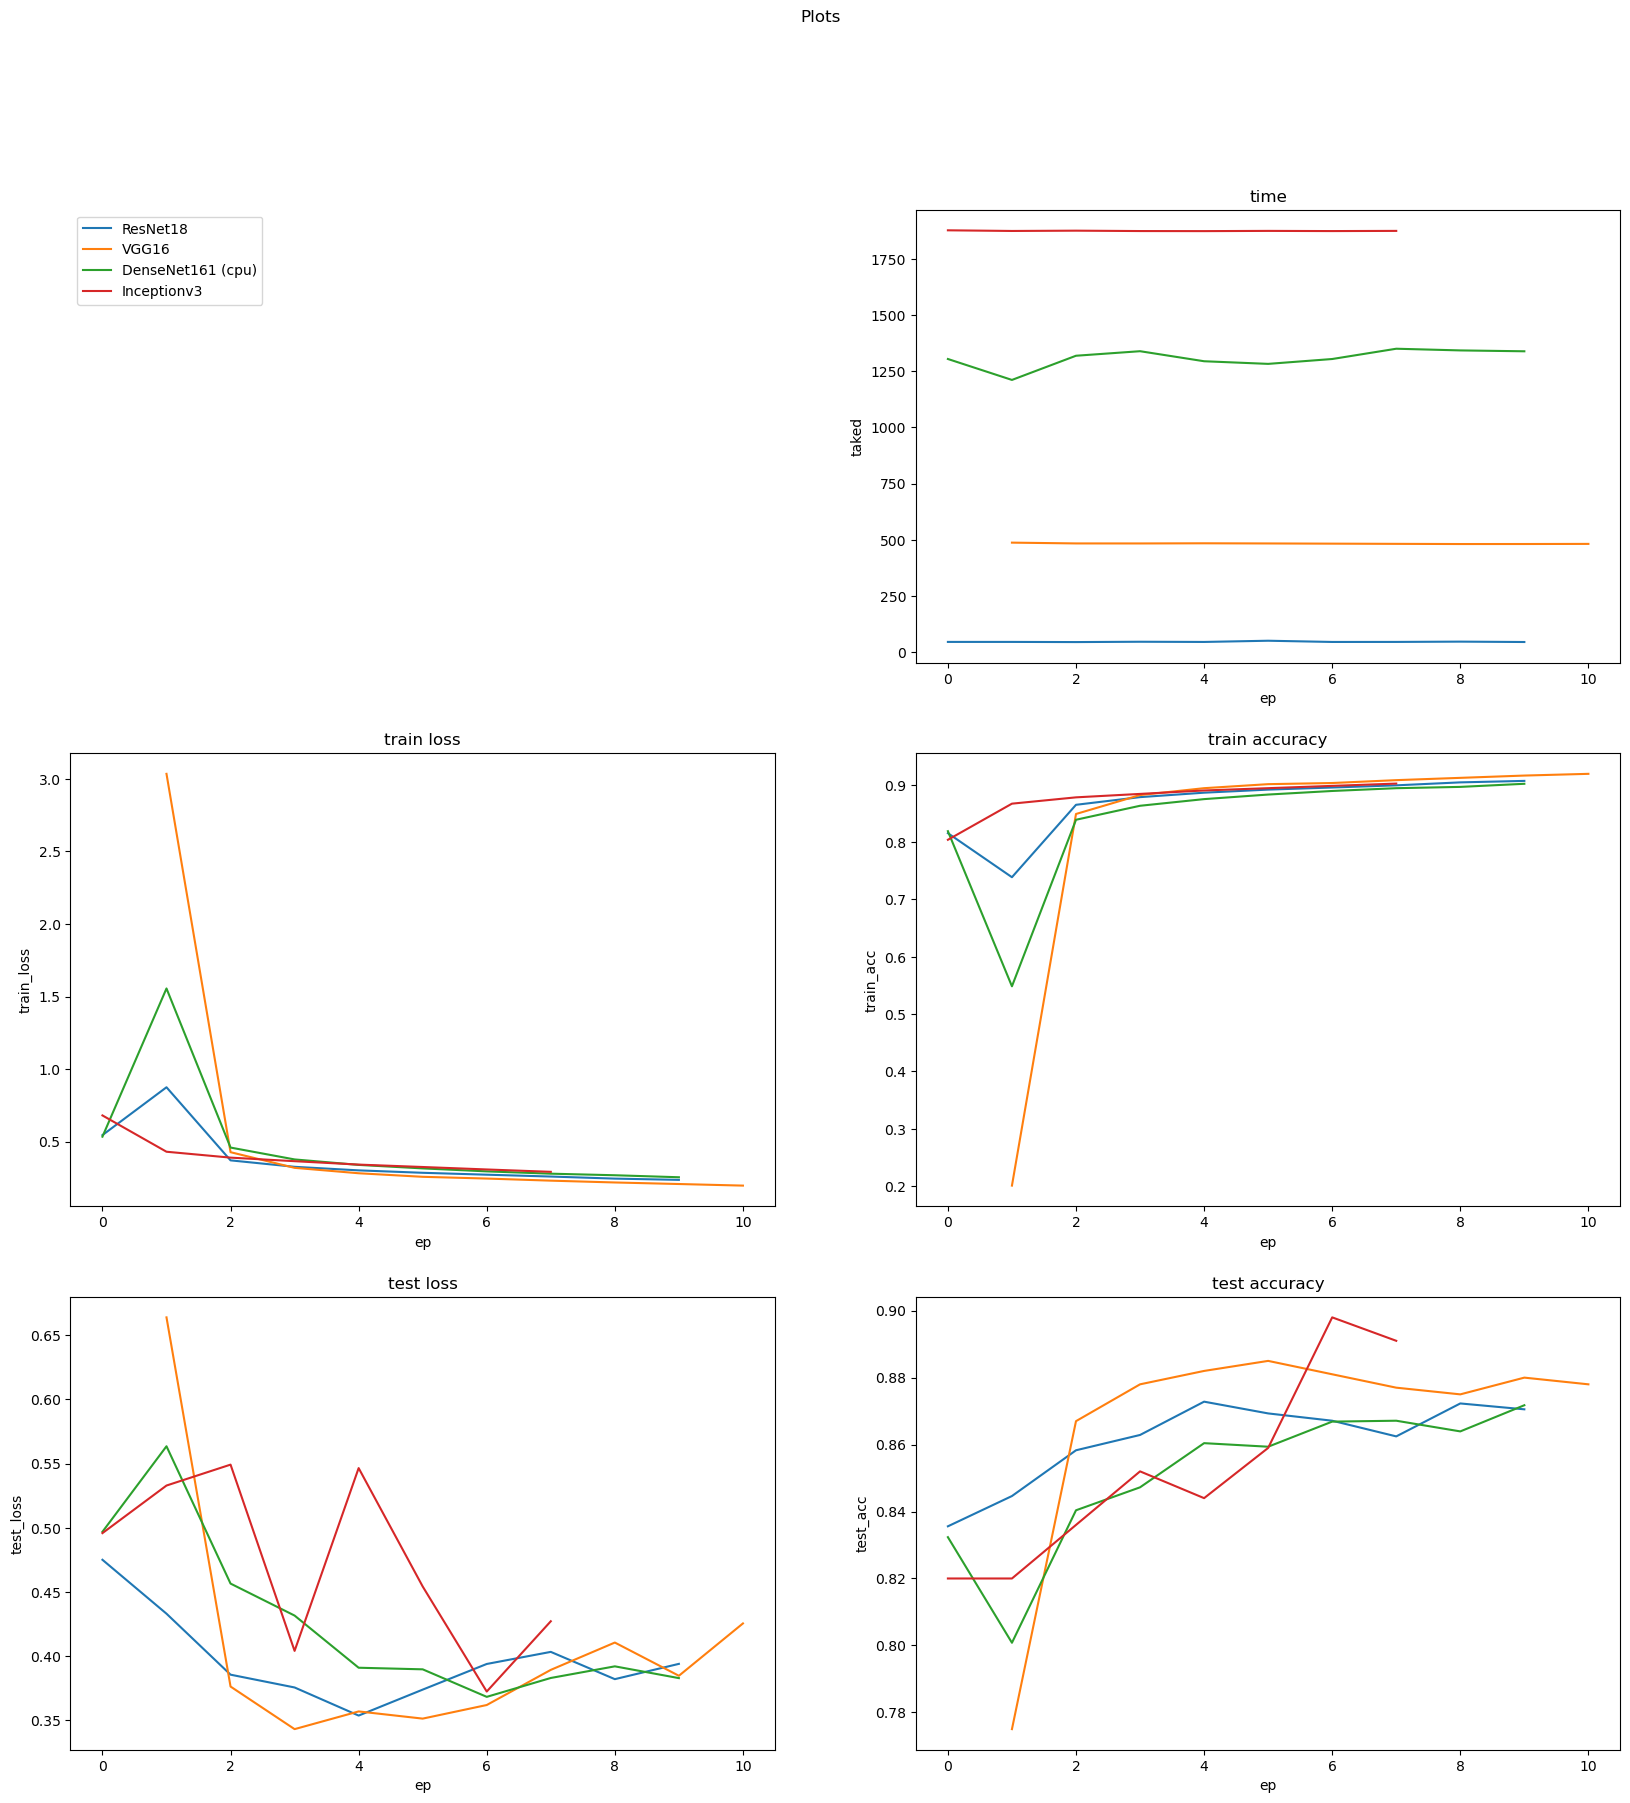

In [ ]:
plt_show(model_dict)

Выводы:  
- самый быстрый ResNet18
- самый точный Densenet161  

Точность примерно у всех на уровне, поэтому лучше брать самый быстрый (по 30 мин на эпоху не прикольно сидеть), а именно ResNet18

## Таблица с результатами

In [ ]:
model_dict

{'model_name': ['ResNet18', 'VGG16', 'DenseNet161 (cpu)', 'Inceptionv3'],
 'ep': [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
  [0, 1, 2, 3, 4, 5, 6, 7]],
 'taked': [[45.39735007286072,
   45.376091957092285,
   44.668147563934326,
   46.11863970756531,
   45.255239486694336,
   50.6323983669281,
   45.21221137046814,
   45.35715389251709,
   46.64669680595398,
   44.95642971992493],
  [487.1, 483.6, 483.5, 484.2, 483.5, 482.6, 481.7, 480.9, 481.0, 481.5],
  [1304.2209334373474,
   1211.0601813793182,
   1318.702866077423,
   1338.8794829845428,
   1294.2152619361877,
   1282.5055041313171,
   1304.1402966976166,
   1349.8962593078613,
   1342.4106829166412,
   1338.5211884975433],
  [1876.8, 1873.9, 1875.2, 1873.5, 1873.2, 1874.2, 1873.4, 1874.2]],
 'train_loss': [[0.5451469163015379,
   0.8748397614769902,
   0.37113708675330415,
   0.32671536039798815,
   0.3021949783960978,
   0.2855101022990883,
   0.2723999098513989,
   0.2

Согласно критериям, все выполнено:
- обучены модели до некоторого улучшения качества
- составлена таблица обучения для сравнения
- использованы все типы моделей